In [1]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from simulation import minimal_model as mm
from surrogate import neural_network

from sampling.grid import Grid
from sampling.random import Random
from sampling.lhs import LatinHyperCube, OrtogonalLatinHyperCube
from sampling.greedy_farpoint import GREEDYFP

from visualise import stream, surface

2024-06-08 18:07:04.223607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 18:07:04.748540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_primes(n):
    out = list()
    sieve = [True] * (n+1)
    for p in range(2, n+1):
        if (sieve[p] and sieve[p]%2==1):
            out.append(p)
            for i in range(p, n+1, p):
                sieve[i] = False
    return out

In [3]:
# All sampling methods instances you want to test.
sampling_methods = [Random, Grid, LatinHyperCube, OrtogonalLatinHyperCube, GREEDYFP]

requested_n = 550
prime = get_primes(int(np.sqrt(requested_n)))[-1]
n_samples = prime**2

# Minimal model testing
g = 1.78
B_lim, D_lim = 2.9, 0.4
bounds = [(0, D_lim), (0, B_lim)]
n_samples

529

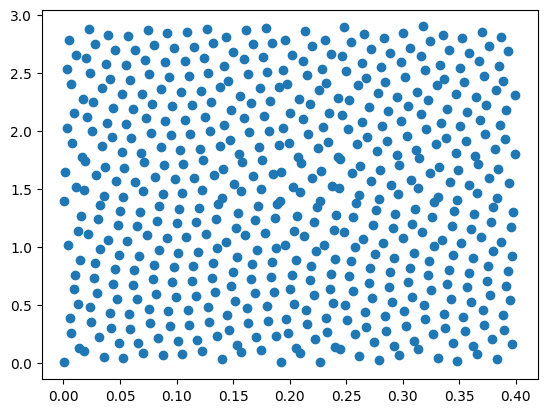

array([[ 0.00579486,  0.00079929, -0.0125893 ],
       [ 0.10242462,  0.0181906 , -0.14352638],
       [ 0.0508605 ,  0.0355819 , -0.06948746],
       [ 0.04316777,  0.0529732 , -0.05391747],
       [ 0.09087593,  0.07036451, -0.08825238],
       [ 0.06771397,  0.08775581, -0.06715276],
       [ 0.07643788,  0.10514712, -0.07028389],
       [ 0.10515149,  0.12253842, -0.08382707],
       [ 0.03141924,  0.13992973, -0.03317097],
       [ 0.09495309,  0.15732103, -0.07619226]])

In [4]:
D_true, B_true = OrtogonalLatinHyperCube.sample_stack([(0, D_lim), (0, B_lim)], n_samples)
plt.scatter(D_true, B_true)
plt.show()
dB_dt, dD_dt = mm.step(B_true, D_true, g, warm_up=0)
points = np.column_stack((B_true.flatten(), D_true.flatten(), dB_dt.flatten()))
points[:10]

In [5]:
# Sample data points (x, y, z)
test_points = np.array([
    [0.5, 0.5, 0],
    [0.75, 0.75, 2],
    [0.25, 0.25, 2],
    [0, 0, -1],
    [0, 1, -1],
    [1, 0, -2],
    [1, 1, -2]
])

# Define the variogram model (simple linear model)
def variogram(x, y):
    return np.linalg.norm(x - y)

# Kriging interpolation function
def kriging_interpolation(points, grid_x, grid_y):
    n = points.shape[0]
    A = np.zeros((n + 1, n + 1))
    b = np.zeros(n + 1)
    
    # Construct the A matrix using variogram values between known points
    for i in range(n):
        for j in range(n):
            A[i, j] = variogram(points[i, :2], points[j, :2])
        A[i, n] = 1  # Adding the constraint
        A[n, i] = 1  # Adding the constraint
    
    A[n, n] = 0  # Regularization term

    Z = points[:, 2]
    
    interpolated_values = np.zeros_like(grid_x)
    
    # Iterate over each grid point
    for gx in range(grid_x.shape[0]):
        for gy in range(grid_x.shape[1]):
            # Construct the b vector using variogram values between grid point and known points
            for i in range(n):
                b[i] = variogram([grid_x[gx, gy], grid_y[gx, gy]], points[i, :2])
            b[n] = 1  # Adding the constraint
            
            # Solve the linear system to get weights
            weights = np.linalg.solve(A, b)
            
            # Calculate the interpolated value using the weights
            interpolated_values[gx, gy] = np.dot(weights[:-1], Z)
    
    return interpolated_values


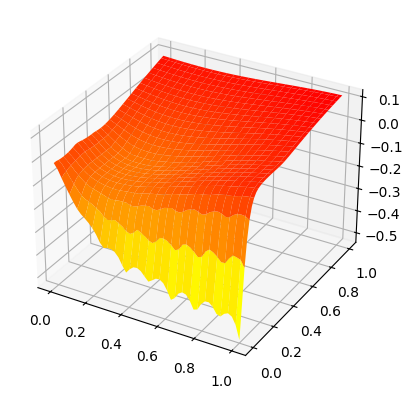

In [6]:
# Define grid
grid_x, grid_y = np.mgrid[0:1:50j, 0:1:50j]
# Perform Kriging interpolation
grid_z = kriging_interpolation(points, grid_x, grid_y)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z, cmap="autumn_r", lw=1, rstride=2, cstride=2)
plt.show()

In [7]:
def create_pdf_from_grid(grid_z):
    # All negatives to positive and invert valus. This will benefit values closer to 0 (equilibrium)
    grid_z = np.abs(grid_z) *  -1

    # Normalize the grid values to create a PDF
    min_val = np.min(grid_z)
    
    # Invert and normalize to make regions near zero have higher probabilities
    inverted_grid_z = min_val - grid_z
    pdf = inverted_grid_z / np.sum(inverted_grid_z)
    
    return pdf

1.0


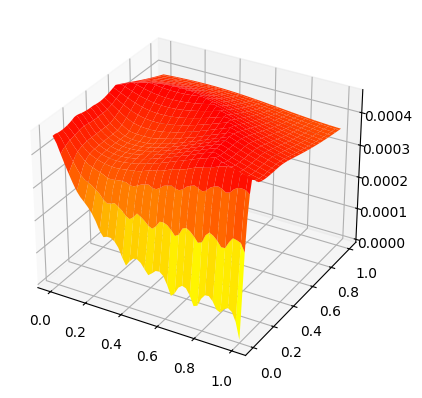

In [8]:
pdf = create_pdf_from_grid(grid_z)
print(pdf.sum())
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(grid_x, grid_y, pdf, cmap="autumn_r", lw=1, rstride=2, cstride=2)
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def weighted_lhs_with_pdf(bounds, n_samples, pdf):
    """
    Perform Latin Hypercube Sampling with weighting based on a given PDF.

    Parameters:
    bounds (list of tuple): List of (min, max) bounds for each dimension.
    n_samples (int): Number of samples to generate.
    pdf (np.ndarray): PDF array corresponding to the grid.

    Returns:
    np.ndarray: Array of shape (n_samples, n_dimensions) with the sampled points.
    """
    n_dimensions = len(bounds)
    lhs_samples = np.zeros((n_samples, n_dimensions))
    
    # Flatten the PDF and calculate cumulative sum
    flat_pdf = pdf.flatten()
    cdf = np.cumsum(flat_pdf)

    # Normalize the CDF
    cdf /= cdf[-1]

    for i in range(n_dimensions):
        # Stratify according to the CDF
        cdf_values = np.linspace(0, 1, n_samples + 1)
        np.random.shuffle(cdf_values[:-1])
        cdf_values = cdf_values[:-1]
        
        # Inverse transform sampling
        inv_cdf_indices = np.searchsorted(cdf, cdf_values, side='right')
        grid_indices = np.unravel_index(inv_cdf_indices, pdf.shape)
        
        # Scale to the bounds
        lhs_samples[:, i] = bounds[i][0] + (bounds[i][1] - bounds[i][0]) * grid_indices[i] / pdf.shape[i]
        
    return lhs_samples

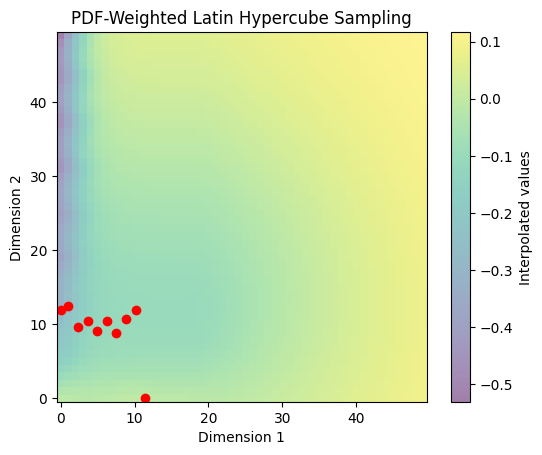

In [10]:
samples = weighted_lhs_with_pdf(((0, 13), (0,13)), 10, pdf)
plt.scatter(samples[:, 0], samples[:, 1], c='r')
plt.imshow(grid_z, origin='lower', alpha=0.5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('PDF-Weighted Latin Hypercube Sampling')
plt.colorbar(label='Interpolated values')

# Setting larger bounds for the axes
# plt.xlim(*bounds[0])
# plt.ylim(*bounds[1])

plt.show()